In [40]:
import numpy as np
import os
import pandas as pd
from scipy.signal import welch
from scipy.stats import entropy
import antropy as ant

# Define EEG frequency bands
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (13, 30),
    'gamma': (30, 45)
}

SAMPLING_RATE = 250  
DATA_DIR = 'preprocessed_data'  
OUTPUT_CSV = 'features_extracted.csv'

def bandpower(epoch, fs, band):
    fmin, fmax = band
    freqs, psd = welch(epoch, fs=fs, nperseg=epoch.shape[-1])
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.sum(psd[idx_band])

def compute_hjorth(epoch):
    """Compute Hjorth activity, mobility, and complexity for a 1D array."""
    diff1 = np.diff(epoch)
    diff2 = np.diff(diff1)
    var_zero = np.var(epoch)
    var_d1 = np.var(diff1)
    var_d2 = np.var(diff2)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero) if var_zero != 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) / mobility if var_d1 != 0 and mobility != 0 else 0
    return activity, mobility, complexity

def extract_features_from_epoch(epoch):
    features = {}
    for i, channel_data in enumerate(epoch):
        # Band powers
        for band_name, band_range in BANDS.items():
            power = bandpower(channel_data, SAMPLING_RATE, band_range)
            features[f'ch_{i+1}_{band_name}_power'] = power

        # Hjorth
        act, mob, comp = compute_hjorth(channel_data)
        features[f'ch_{i+1}_hjorth_activity'] = act
        features[f'ch_{i+1}_hjorth_mobility'] = mob
        features[f'ch_{i+1}_hjorth_complexity'] = comp

        # Spectral entropy
        try:
            features[f'ch_{i+1}_spectral_entropy'] = ant.spectral_entropy(channel_data, sf=SAMPLING_RATE, method='welch', normalize=True)
        except Exception as e:
            features[f'ch_{i+1}_spectral_entropy'] = np.nan
    return features

def main():
    all_features = []

    for filename in os.listdir(DATA_DIR):
        if filename.endswith('.npy'):
            file_path = os.path.join(DATA_DIR, filename)
            data = np.load(file_path)  # Shape: (n_epochs, 63, 500)

            print(f"Processing {filename} - shape: {data.shape}")
            label_parts = filename.replace('.npy', '').split('_')
            session = "_".join(label_parts[:3])  # e.g., Design_2_1
            label = label_parts[3] if len(label_parts) > 3 else 'unknown'

            for epoch_idx, epoch in enumerate(data):
                features = extract_features_from_epoch(epoch)
                features['epoch'] = epoch_idx
                features['session'] = session
                features['label'] = label
                all_features.append(features)

    df = pd.DataFrame(all_features)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✅ Feature extraction complete. Saved to {OUTPUT_CSV}")

if __name__ == '__main__':
    main()

Processing Design_2_1_IE_epochs.npy - shape: (123, 63, 500)
Processing Design_2_1_IG_epochs.npy - shape: (159, 63, 500)
Processing Design_2_1_PU_epochs.npy - shape: (21, 63, 500)
Processing Design_2_1_RIE_epochs.npy - shape: (13, 63, 500)
Processing Design_2_1_RIG_epochs.npy - shape: (25, 63, 500)
Processing Design_2_2_IE_epochs.npy - shape: (149, 63, 500)
Processing Design_2_2_IG_epochs.npy - shape: (203, 63, 500)
Processing Design_2_2_PU_epochs.npy - shape: (47, 63, 500)
Processing Design_2_2_RIE_epochs.npy - shape: (39, 63, 500)
Processing Design_2_2_RIG_epochs.npy - shape: (41, 63, 500)
Processing Design_2_3_IE_epochs.npy - shape: (105, 63, 500)
Processing Design_2_3_IG_epochs.npy - shape: (137, 63, 500)
Processing Design_2_3_PU_epochs.npy - shape: (21, 63, 500)
Processing Design_2_3_RIE_epochs.npy - shape: (33, 63, 500)
Processing Design_2_3_RIG_epochs.npy - shape: (31, 63, 500)
Processing Design_2_4_IE_epochs.npy - shape: (147, 63, 500)
Processing Design_2_4_IG_epochs.npy - shape

In [58]:
df = pd.read_csv("features_extracted.csv")

C:\Users\ssr17\AppData\Local\Temp\ipykernel_7780\1316995423.py:1: DtypeWarning: Columns (570) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("features_extracted.csv")


In [60]:
df.loc[df['session'].str.contains('RST1'), 'label'] = 'RST1'
df.loc[df['session'].str.contains('RST2'), 'label'] = 'RST2'
df.to_csv("features_extracted.csv", index=False)

C:\Users\ssr17\AppData\Local\Temp\ipykernel_7780\2979736036.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_melted, x="Band", y="Power", hue="Label", ci="sd", capsize=0.1)


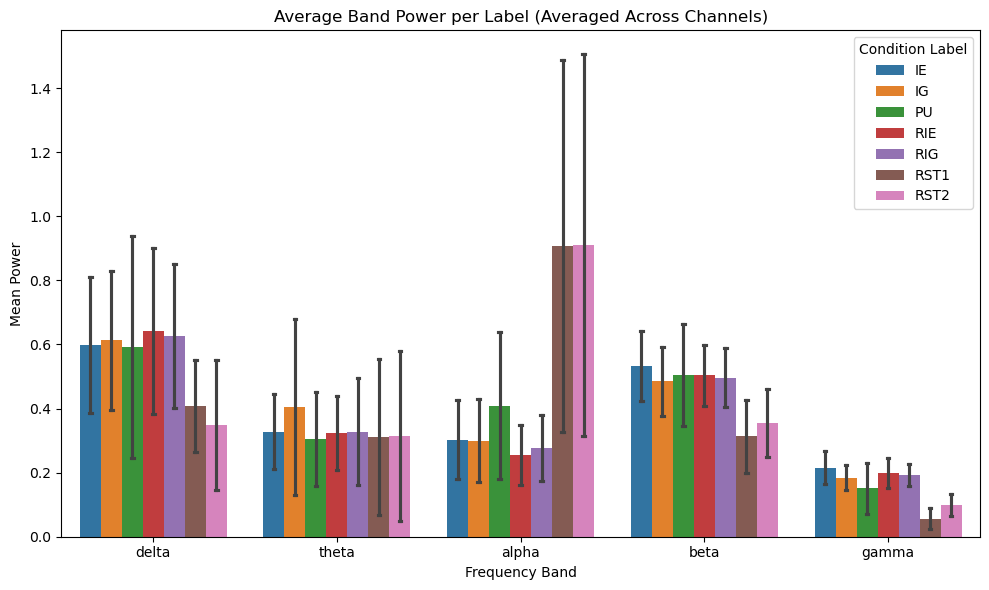

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

df = pd.read_csv("features_extracted.csv")

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

band_power = {band: [] for band in bands}

for i, row in df.iterrows():
    for band in bands:
        band_cols = [col for col in df.columns if re.match(fr'ch_\d+_{band}_power$', col)]
        band_power[band].append(row[band_cols].mean())
avg_df = pd.DataFrame(band_power)
avg_df["Label"] = df["label"]

df_melted = avg_df.melt(id_vars="Label", var_name="Band", value_name="Power")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Band", y="Power", hue="Label", ci="sd", capsize=0.1)
plt.title("Average Band Power per Label (Averaged Across Channels)")
plt.ylabel("Mean Power")
plt.xlabel("Frequency Band")
plt.legend(title="Condition Label")
plt.tight_layout()
plt.show()


C:\Users\ssr17\AppData\Local\Temp\ipykernel_7780\3546600463.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_melted, x="Label", y="Power", hue="Band", ci="sd", capsize=0.1)


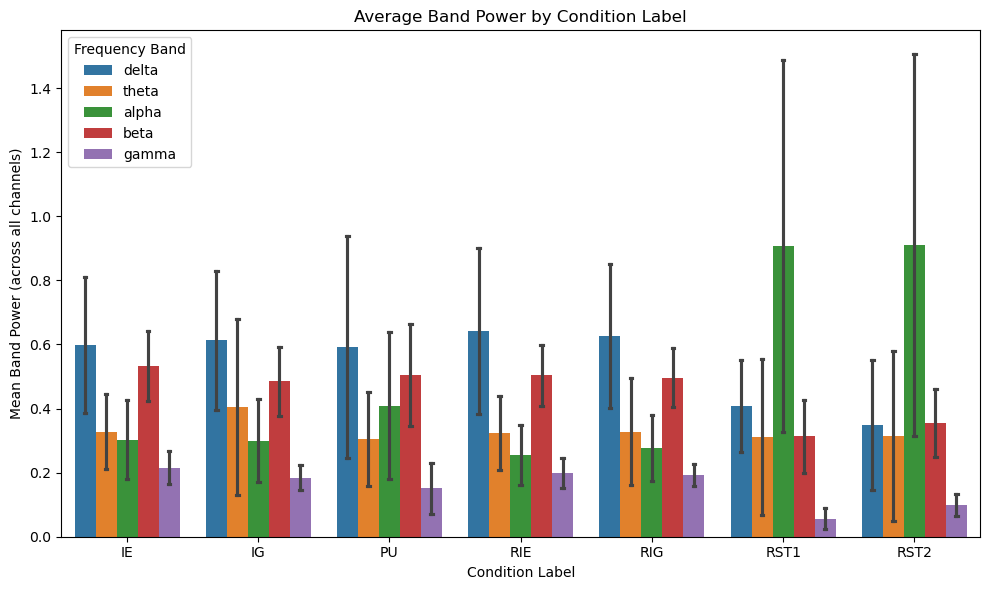

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Load your feature file
df = pd.read_csv("features_extracted.csv")

# List of bands to include
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Aggregate across all channels per band
band_power = {band: [] for band in bands}
labels = []

for i, row in df.iterrows():
    for band in bands:
        band_cols = [col for col in df.columns if re.match(fr'ch_\d+_{band}_power$', col)]
        band_power[band].append(row[band_cols].mean())
    labels.append(row['label'])

# Create DataFrame
avg_df = pd.DataFrame(band_power)
avg_df['Label'] = labels

# Melt the dataframe to long format for seaborn
df_melted = avg_df.melt(id_vars="Label", var_name="Band", value_name="Power")

# Plot: X = Label, Bars = Band
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Label", y="Power", hue="Band", ci="sd", capsize=0.1)

plt.title("Average Band Power by Condition Label")
plt.xlabel("Condition Label")
plt.ylabel("Mean Band Power (across all channels)")
plt.legend(title="Frequency Band")
plt.tight_layout()
plt.show()